In [ ]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [ ]:
USE_CUDA = torch.cuda.is_available()

<h2>Replay Buffer</h2>

In [ ]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # print("State shape:", state.shape)
        # print("Next state shape:", next_state.shape)
        
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Cart Pole Environment</h2>

In [ ]:
env_id = "CartPole-v0"
env = gym.make(env_id)

In [ ]:
env.action_space

<h2>Epsilon greedy exploration</h2>

In [ ]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [ ]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<h2>Deep Q Network</h2>

In [ ]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions, device='cuda'):
        super(DQN, self).__init__()
        
        self.device = device
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        ).to(self.device)
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():  # Ensures that no gradients are computed, which saves memory and computations
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # Convert state to tensor and add batch dimension
                q_value = self.forward(state)  # Get Q-values for all actions
                action = q_value.max(1)[1].item()  # Get the action with the maximum Q-value and convert to integer
        else:
            action = random.randrange(self.num_actions)
        return action
    


In [ ]:
if USE_CUDA:
    model = DQN(env.observation_space.shape[0], env.action_space.n)
else:
    model = DQN(env.observation_space.shape[0], env.action_space.n, device='cpu')
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

In [ ]:
USE_CUDA

<h2>Computing Temporal Difference Loss</h2>

In [ ]:
def compute_td_loss(batch_size, replay_buffer, model, gamma, optimizer):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert numpy arrays to torch tensors
    state = torch.FloatTensor(state).to(model.device)
    next_state = torch.FloatTensor(next_state).to(model.device)
    action = torch.LongTensor(action).to(model.device)
    reward = torch.FloatTensor(reward).to(model.device)
    done = torch.FloatTensor(done).to(model.device)

    # Compute Q-values for current states
    q_values = model(state)

    # Compute Q-values for next states using no gradient computation to speed up and reduce memory usage
    with torch.no_grad():
        next_q_values = model(next_state)
        next_q_value = next_q_values.max(1)[0]  # Get the max Q-value along the action dimension

    # Calculate the expected Q-values
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    # Compute the loss between actual Q values and the expected Q values
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    loss = (q_value - expected_q_value.detach()).pow(2).mean()  # Detach expected_q_value to prevent gradients from flowing

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


In [ ]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

In [180]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state, info = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    # print(f"Select action: {action}. type: {type(action)}")
    next_state, reward, terminated, truncated, info = env.step(action)
 
    
    replay_buffer.push(state, action, reward, next_state, terminated)
    
    state = next_state
    episode_reward += reward
    
    if terminated:
        state, info = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size, replay_buffer, model, gamma, optimizer)
        losses.append(loss.data.item())
        
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

KeyboardInterrupt: 

<p><hr></p>

<h1>Atari Environment</h1>

In [ ]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [ ]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [181]:
import torch
import torch.nn as nn
import numpy as np
import random

class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions, device='cuda'):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.device = device
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        ).to(self.device)
        
        # Precompute the feature size to avoid dynamic computation
        self._feature_size = self._compute_feature_size()
        
        self.fc = nn.Sequential(
            nn.Linear(self._feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        ).to(self.device)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def _compute_feature_size(self):
        # Use dummy data to calculate size
        with torch.no_grad():
            dummy_input = torch.zeros(1, *self.input_shape).to(self.device)
            output = self.features(dummy_input)
            print(output.shape)
            return int(np.prod(output.size()))

    def act(self, state, epsilon, env):
        if random.random() > epsilon:
            with torch.no_grad():  # Ensures that no gradients are computed
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # Convert state to tensor and add batch dimension
                q_values = self.forward(state_tensor)
                action = q_values.max(1)[1].item()  # Get the action with the maximum Q-value and convert to integer
        else:
            action = random.randrange(env.action_space.n)
        return action


In [182]:
if USE_CUDA:
    model = DQN(env.observation_space.shape[0], env.action_space.n)
else:
    model = DQN(env.observation_space.shape[0], env.action_space.n, device='cpu')
    
optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [183]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

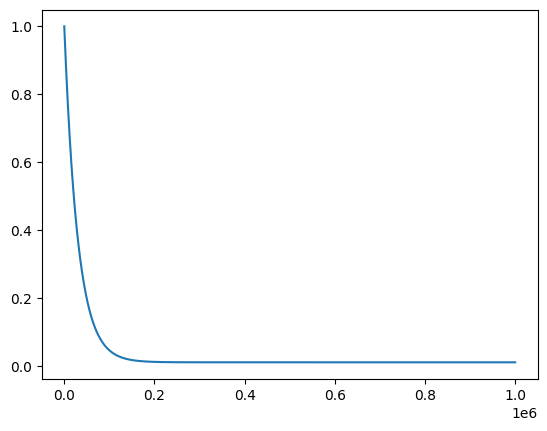

In [184]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

In [186]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state, info = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    # print(f"Select action: {action}. type: {type(action)}")
    next_state, reward, terminated, truncated, info = env.step(action)
 
    
    replay_buffer.push(state, action, reward, next_state, terminated)
    
    state = next_state
    episode_reward += reward
    
    if terminated:
        state, info = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size, replay_buffer, model, gamma, optimizer)
        losses.append(loss.data.item())
        
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.